### Task 2
### Kolesov Aleksandr (M05-004a)

In [361]:
import torch

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm_notebook

### 1. Data for the experiment 

In [625]:
X,y = load_breast_cancer( return_X_y=True, as_frame=False)

In [626]:
X.shape,y.shape

((569, 30), (569,))

In [627]:
X_train, X_test, y_train, y_test =  train_test_split(X,y,train_size=0.3)

In [628]:
(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

((170, 30), (399, 30), (170,), (399,))

Thus, we get our $\textbf{X}$ $\in \mathbb{R}^{m x n}$, where m = 170 and n = 30. Ath the same time $y \in \{+- 1\}^{m}$ This matrix is data for the training of the model.


Moreover, this lab is supported by PyTorch framework , hence one should transform all numpy arrays to torch tensors

In [629]:
mask_train = np.where(y_train == 0)
mask_test = np.where(y_test == 0)
y_train[mask_train] = -1
y_test[mask_test] = -1

In [630]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train)

In [631]:
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test)

### 1. Likelihood

Our likelihood model is $p(y|x, w) = \prod_{j=1}^{m} \sigma (y_{j}w^{T}x_{j})$, the following class constitutes such probabilistic model with its methods

In [632]:
class Likelihood_model:
    
    def __init__(self, weights):
        
        """
        weights : torch.tensor of shape 1 x n
        
        """
        self.weights = weights
        
    def get_weights(self):
        
        """
        return a current weight of a model
        
        return : torch.tensor of shape 1 x n
        """
        return self.weights
        
    def compute_likelihood(self, y, x):
        
        """
        y : torch.tensor of shape m x 1
        x : torch.tensor of shape m x n
        w : torch.tensor of shape 1 x n
        
        returns : torch.tensor of shape 1 x 1  (value)
        
        """
        x = x.reshape(-1, self.weights.shape[1] )
        y = y.reshape(-1, 1)
         
        term = torch.stack( [-y * (self.weights@x.T).T] , dim = 0 )
         
        term = term.squeeze()
         
        return  1 / (1 + torch.exp(term)) , torch.prod(  1 / (1 + torch.exp(term))  , dim = 0)


    def first_derivative(self,y,x):
        
        """
        The derivative of likelihood by weight
        
        y : torch.tensor of shape m x 1
        x : torch.tensor of shape m x n
        
        returns: torch.tensor of shape n 
        
        """
        
        likelihood,_ = self.compute_likelihood(y, x) # torch.tensor of shape  m
        
       
         
        y = y.reshape(-1,1)
        derivative = torch.stack([-x*y], dim = 0).squeeze() # torch.tensor of shape m x n
        
            
        current_derivative = [0]*((likelihood.shape[0]))
        result = torch.zeros_like(derivative[-1])
        
        for i in range(likelihood.shape[0]):
            current_derivative[i] = - derivative[i] + (1 + (- y[i]* (self.weights@x[i].T).T)) 
             
            
        
        for i in range(len(current_derivative)):
            result += current_derivative[i]
            
         
            
         
        return result
        
    def second_derivative(self,y,x):
        
        """
        y: torch.tensor of shape 1 x m
        x: torch.tensor of shape n x m
        
        """
        likelihood = self.compute_likelihood(y, x)
        derivative = (-x @ y.T).pow(2)
        return derivative * likelihood *( 1 - likelihood)*(1 - 2*likelihood)

### 2. Prior Distribution

In [646]:
class Prior:
    
    def __init__(self, variances):
        
        """
        Probability distibution of prior
        n - dimensional with diagonal covariance matrix
        
        variances: torch.tensor of shape  n : (torch.ones(5))
        
        """
        self.variances = variances
        self.locs      = torch.zeros(variances.shape)
        normal         = torch.distributions.normal.Normal(self.locs, self.variances )
        self.distribution = torch.distributions.independent.Independent(normal , 1)
        
        
    def log_probability(self, w):
        
        """
        log_probability at current point x
        
        w : torch.tensor of shape 1 x n
        returns : torch.tensor of shape 1 x 1
        
        """
        
        return self.distribution.log_prob(w)
    
    
    def sample(self, n_counts):
        
        """
        sample element from prior distribution
        
        n_counts :  num samples that are desirable to sample
        returns :   torch.tensor of shape n_counts x n
        
        """
        return self.distribution.sample(torch.tensor([n_counts]))
    
    def first_derivative(self, w):
        
        """
        The derivative of log-density by weight with fixed A
        
        w: torch.tensor of shape 1 x n
        
        returns: torch.tensor of shape  n x 1
        """
        return torch.diag(self.variances)@w.T
    
    def second_derivative(self, w):
        return 0.5*(torch.diag(self.variances) - torch.diag(self.variances)@w.T@w@torch.diag(self.variances))

### 3. Theory

We can calculate likelihood of our model and know prior distribution. Then , one can pay our attention to Bayes theorem:

- $p(y,w|X, A) = p(y|X,w) p(w|A) $   =   $\prod_{j=1}^{n} \sigma(y_{j}w^{T} x_{j})$ $\mathcal{N} (0,A^{-1})$

It is worth noticing that $A = diag(\alpha)$. 

- One would like to select such parameters of prioir distribution which can naximize evidence 

$$ A^{*} = \arg \max_{A} \int p(y|X,w) p(w|A) dw $$

Let $Q(w) = p(y|X,w) p(w|A)$

Since we cannot integrate, then one can use Taylor expansion near Maximum posterior point(MAP)

$$ \log Q(w) \sim \log Q(w_{MAP}) + \frac{1}{2}(w - w_{MAP})^{T} \nabla \nabla \log Q(w_{MAP})(w -w_{MAP}) $$

However, MAP point depends on A, though A is not optimized.

Then , Algorithm:

- 1. calculate W_{MAP} through fixed A 
- 2. Optimize the functional of Laplace's approximation through parameters of A 

$$ p(y, w|X, A) = \prod_{j=1}^{m} \sigma(y_{j} w^{T} x_{j}) \frac{\sqrt{detA}}{(2 \pi)^{n/2}}e^{-\frac{1}{2}w^{T}Aw}$$

### 4. Calculation w_MAP

- First derivative of Q(w) to find out w_MAP

$$ \nabla_{w} Q(w)  = \nabla_{w} (p(y|X,w)p(w|A)) = 0$$

First of all, we find the point, where the first dervative of Q is equal to zero - that is w_MAP

Undoubtedly, we consider logarithm of this function Q and in the above classes, methods of first derivative takes in mind this fact

$$ \nabla_{w} \log Q(w) = \nabla_{w} \log p(w|A) + \nabla_{w} (\log \sigma_{1} + ... + \log \sigma_{m}) ->  \min_{w}$$

In other words, I want to select such parameters that this first derivative of the function equals to zero

In [661]:
weights = torch.rand(1,30)
init_weights = weights.clone()
weights = torch.nn.Parameter(weights, requires_grad = True)

optimizer = torch.optim.SGD([weights], lr=1e-4,  weight_decay=1e-6, momentum=0.9, nesterov=True )
like_model = Likelihood_model(weights)
prior = Prior(torch.ones(30))

num_iterations = 50


history = [0]*(num_iterations)
 
for iteration in tqdm_notebook(range(num_iterations)):
    
    optimizer.zero_grad()
    log_model_derivative = like_model.first_derivative(y_train.unsqueeze(0), X_train).unsqueeze(-1) # with gradient torch.Size([30,1])
    
    current_weights = like_model.get_weights()
    log_prior_derivative = prior.first_derivative(current_weights) # with gradient torch.Size([30,1])
     
    loss_vector =  ( log_model_derivative +  log_prior_derivative) # with gradient  torch.Size ([30,1])
    
    (torch.sum(loss_vector, dim=0)).backward()
    history[iteration] =  torch.sum(loss_vector,dim=0).item() 
    optimizer.step()

<ipython-input-661-987765d9c3bb>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for iteration in tqdm_notebook(range(num_iterations)):


  0%|          | 0/50 [00:00<?, ?it/s]

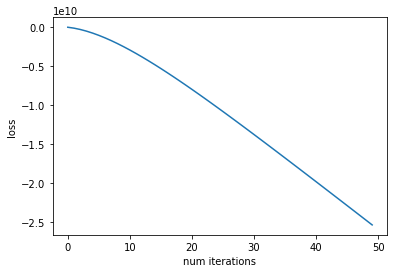

In [662]:
plt.plot(np.arange(50),history)
plt.xlabel("num iterations")
plt.ylabel('loss')
plt.show()

Slightly, optimized weights of our model one can move on to the following step, to tune parameters of prior distribution

In [663]:
weights_map = weights

### 5. Finding optimal parameters of A

Now, we will learn diagonal elements of covariance matrix and weights of the model simultaneously be the abovemetioned formula

In [685]:
weights = torch.rand(1,30)
variances = 30*torch.ones(30)
init_weights = weights.clone()
weights = torch.nn.Parameter(weights, requires_grad = True)
variances = torch.nn.Parameter(variances, requires_grad = True)

optimizer = torch.optim.SGD([weights, variances], lr=1e-1,  weight_decay=1e-6, momentum=0.9, nesterov=True )
like_model = Likelihood_model(weights)
prior = Prior(variances)

num_iterations = 1


history = [0]*(num_iterations)
 
for iteration in tqdm_notebook(range(num_iterations)):
    
    optimizer.zero_grad()
    log_model = like_model.compute_likelihood(y_train.unsqueeze(0), X_train)[-1]
    
    current_weights = like_model.get_weights()
    log_prior = prior.log_probability(current_weights).squeeze()
    
    
    
    difference = weights - weights_map
    #log_model_derivative = like_model.second_derivative(y_train.unsqueeze(0), X_train).unsqueeze(-1) # with gradient torch.Size([30,30])
    
     
    log_prior_derivative = prior.second_derivative(current_weights) # with gradient torch.Size([30,30])
    second_derivative = log_prior_derivative # + log_model_derivative
    
    loss = log_model + log_prior + 0.5*difference@second_derivative@difference.T
    
    loss.backward()
    history[iteration] = loss.item() 
    optimizer.step()

<ipython-input-685-3d292bf8b4fe>:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for iteration in tqdm_notebook(range(num_iterations)):


  0%|          | 0/1 [00:00<?, ?it/s]

In [689]:
variances.detach()

tensor([-8.0368e+06, -1.9374e+07, -1.9204e+07,  2.2394e+08, -3.5310e+04,
         1.3393e+04,  8.3734e+03,  2.7870e+04, -1.3340e+05, -6.6861e+04,
         2.3807e+04, -2.2120e+06,  1.3035e+05,  3.5273e+07, -3.5776e+03,
        -5.7271e+03,  6.1341e+03, -4.5109e+02, -6.8206e+03,  2.1489e+03,
        -4.6446e+06, -1.9914e+07, -2.3927e+06,  6.9721e+07, -1.2142e+05,
         3.9885e+04,  9.0345e+04,  1.0181e+05, -1.7248e+05, -2.2190e+04])

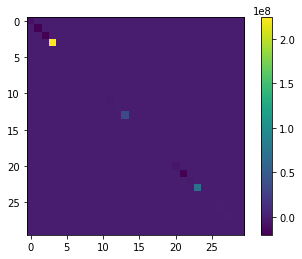

In [694]:
plt.imshow(torch.diag(variances.detach()).numpy())
plt.colorbar()

It is worth noticing,that I didn't manage to outperform normal analysis due to nan exploison when claculate likelihood of model, that is why necessary I should pay my attention to LogSumExp trick to repeat this work again and get better results